In [1]:
# needed installation/s 

#for unzipping .7z 
!pip install py7zr

In [2]:
# import necessary libraries
import xml.etree.ElementTree as ET
import pandas as pd
import py7zr
import os, os.path
import sqlite3
import tempfile
import matplotlib.pyplot as plt

In [3]:
# unzip .7z files and create directories on the Desktop for each website

archive = py7zr.SevenZipFile('../Downloads/ai.stackexchange.com.7z', mode='r')
archive.extractall(path="../Desktop/AI")

archive = py7zr.SevenZipFile('../Downloads/cs.stackexchange.com.7z', mode='r')
archive.extractall(path="../Desktop/CS")

archive = py7zr.SevenZipFile('../Downloads/robotics.stackexchange.com.7z', mode='r')
archive.extractall(path="../Desktop/Robotics")

In [4]:
# converting xml files to csv

def xml2csv(fname, delcols=[]):
    tree = ET.parse(fname)
    root = tree.getroot()
    d = pd.DataFrame([e.attrib for e in root])
    for name in delcols: del d[name]
    d.to_csv(fname+".csv", index=False)

#for AI
xml2csv("./AI/Users.xml")
xml2csv("./AI/Posts.xml")
xml2csv("./AI/Comments.xml")

# for robotics data
xml2csv("./Robotics/Users.xml")
xml2csv("./Robotics/Posts.xml")
xml2csv("./Robotics/Comments.xml")

# for cs data
xml2csv("./CS/Users.xml")
xml2csv("./CS/Posts.xml")
xml2csv("./CS/Comments.xml")


In [5]:
# Read .csv files 

# for AI
# Importing the Posts files
AIPosts = pd.read_csv('./AI/Posts.xml.csv')
# Importing the users files
AIUsers = pd.read_csv('./AI/Users.xml.csv')
AIComments = pd.read_csv('./AI/Comments.xml.csv')

# for CS
# Importing the Posts files
CSPosts = pd.read_csv('./CS/Posts.xml.csv')
# Importing the users files
CSUsers = pd.read_csv('./CS/Users.xml.csv')
CSComments = pd.read_csv('./CS/Comments.xml.csv')

# for Robotics
# Importing the Posts files
RoboticsPosts = pd.read_csv('./Robotics/Posts.xml.csv')
# Importing the users files
RoboticsUsers = pd.read_csv('./Robotics/Users.xml.csv')
RoboticsComments = pd.read_csv('./Robotics/Comments.xml.csv')


C:\Users\seyda\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (16,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# create Database for AI dataset
db = os.path.join(tempfile.mkdtemp(), 'solutions.db')
if os.path.isfile(db):
    os.remove(db)

# create the connection
conn = sqlite3.connect(db)

# import the data frame into the database
AIPosts.to_sql('AIPosts', conn)
AIUsers.to_sql('AIUsers', conn)
AIComments.to_sql('AIComments', conn)

RoboticsPosts.to_sql('RoboticsPosts', conn)
RoboticsUsers.to_sql('RoboticsUsers', conn)
RoboticsComments.to_sql('RoboticsComments', conn)

CSPosts.to_sql('CSPosts', conn)
CSUsers.to_sql('CSUsers', conn)
CSComments.to_sql('CSComments', conn)


In [7]:
# executing sql on dataset showing how many users created each year for robotics
sql_r_1 = pd.read_sql_query("""
SELECT STRFTIME('%Y', CreationDate) AS Year, COUNT(*) AS Robotics
FROM RoboticsUSers
GROUP BY Year
""", conn)
sql_r_1

,Year,Robotics
0,2012,660
1,2013,1664
2,2014,2100
3,2015,2361
4,2016,2933
5,2017,3292
6,2018,2743
7,2019,2436
8,2020,2196
9,2021,2455


In [8]:
# executing sql on dataset showing how many users created each year for AI
sql_a_1 = pd.read_sql_query("""
SELECT STRFTIME('%Y', CreationDate) AS Year, COUNT(*) AS AI
FROM AIUSers
GROUP BY Year
""", conn)
sql_a_1

,Year,AI
0,2016,3429
1,2017,7026
2,2018,7964
3,2019,9090
4,2020,8679
5,2021,7602
6,2022,13431
7,2023,9408


In [9]:
# executing sql on dataset showing how many users created each year for CS
sql_c_1 = pd.read_sql_query("""
SELECT STRFTIME('%Y', CreationDate) AS Year, COUNT(*) AS CS
FROM CSUSers
GROUP BY Year
""", conn)
sql_c_1

,Year,CS
0,2012,4005
1,2013,5682
2,2014,9844
3,2015,11788
4,2016,16181
5,2017,16956
6,2018,14611
7,2019,14141
8,2020,14122
9,2021,12256


In [10]:
# merge data frames for plotting

df = pd.merge(sql_r_1, sql_a_1, on='Year',how='outer')
df = pd.merge(df, sql_c_1, on='Year',how='outer')
df

,Year,Robotics,AI,CS
0,2012,660,NaN,4005
1,2013,1664,NaN,5682
2,2014,2100,NaN,9844
3,2015,2361,NaN,11788
4,2016,2933,3429.0,16181
5,2017,3292,7026.0,16956
6,2018,2743,7964.0,14611
7,2019,2436,9090.0,14141
8,2020,2196,8679.0,14122
9,2021,2455,7602.0,12256


Text(0, 0.5, 'Number of Users')

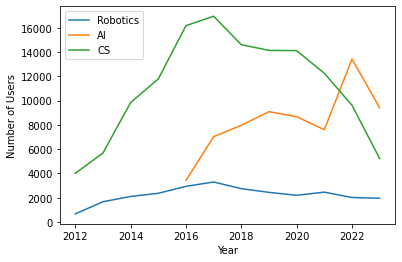

In [11]:
# Create an axes object 
axes = plt.gca()

# pass the axes object to plot function
df.plot(kind='line', x='Year', y='Robotics', ax=axes);
df.plot(kind='line', x='Year', y='AI', ax=axes);
df.plot(kind='line', x='Year', y='CS', ax=axes);
plt.xlabel("Year")
plt.ylabel("Number of Users")

In [14]:
# I find this query not very useful so I decided to skip it
sql1 = pd.read_sql_query("""
SELECT RoboticsUsers.Id, CommentUsers.TotalComment, PostUsers.TotalPost
FROM RoboticsUsers
JOIN (
        SELECT COUNT(*) AS TotalComment, UserId
        FROM RoboticsComments
        GROUP BY UserId
        ) AS CommentUsers
        ON CommentUsers.UserId = RoboticsUsers.Id
JOIN (
        SELECT COUNT(*) AS TotalPost, OwnerUserId
        FROM RoboticsPosts
        GROUP BY OwnerUserId
        ) AS PostUsers
        ON PostUsers.OwnerUserId = RoboticsUsers.Id
""", conn)
sql1

,Id,TotalComment,TotalPost
0,-1,18,76
1,12,6,2
2,13,11,4
3,16,10,1
4,21,13,9
...,...,...,...
2891,36071,1,1
2892,36074,1,1
2893,36109,1,1
2894,36125,1,1
